In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Deep_learning_final

/content/drive/MyDrive/Colab Notebooks/Deep_learning_final


In [ ]:
# data_loader.py
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


def load_cifar10(batch_size=32, num_workers=2, train_val_split=0.9):
    """
    Load and prepare CIFAR-10 dataset with train/validation split

    Args:
        batch_size (int): Size of each batch
        num_workers (int): Number of workers for data loading
        train_val_split (float): Ratio of training data to total data

    Returns:
        tuple: (train_loader, val_loader, class_names)
    """
    # CIFAR-10 normalization constants
    NORM_MEAN = (0.4914, 0.4822, 0.4465)
    NORM_STD = (0.2023, 0.1994, 0.2010)

    # Define transforms
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(NORM_MEAN, NORM_STD)]
    )

    # Load dataset
    dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )

    # Split into train and validation sets
    train_size = int(len(dataset) * train_val_split)
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader, dataset.classes

In [ ]:
# model_loader.py
import torch
import torchvision.models as models


def load_model(model_name="resnet18", pretrained=True):
    """
    Load and prepare the model for adversarial attack

    Args:
        model_name (str): Name of the model architecture
        pretrained (bool): Whether to use pretrained weights

    Returns:
        torch.nn.Module: Prepared model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_name.lower() == "resnet18":
        model = models.resnet18(pretrained=pretrained)
    elif model_name.lower() == "resnet50":
        model = models.resnet50(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    model = model.to(device)
    model.eval()  # Set to evaluation mode

    return model, device

In [ ]:
# patch_generator.py
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np


class PatchGenerator:
    def __init__(
        self,
        model,
        device,
        norm_mean=(0.4914, 0.4822, 0.4465),
        norm_std=(0.2023, 0.1994, 0.2010),
    ):
        self.model = model
        self.device = device
        self.norm_mean = torch.FloatTensor(norm_mean)[:, None, None].to(device)
        self.norm_std = torch.FloatTensor(norm_std)[:, None, None].to(device)

    def _normalize_patch(self, patch):
        """Normalize patch values to match dataset normalization"""
        return (torch.tanh(patch) + 1 - 2 * self.norm_mean) / (2 * self.norm_std)

    def place_patch(self, images, patch, random_location=True):
        """Apply the adversarial patch to images"""
        patched_images = images.clone()
        patch_h, patch_w = patch.shape[-2:]

        if random_location:
            for i in range(images.shape[0]):
                h_offset = np.random.randint(0, images.shape[2] - patch_h - 1)
                w_offset = np.random.randint(0, images.shape[3] - patch_w - 1)
                patched_images[
                    i, :, h_offset : h_offset + patch_h, w_offset : w_offset + patch_w
                ] = self._normalize_patch(patch)
        else:
            # Center the patch
            h_offset = (images.shape[2] - patch_h) // 2
            w_offset = (images.shape[3] - patch_w) // 2
            patched_images[
                :, :, h_offset : h_offset + patch_h, w_offset : w_offset + patch_w
            ] = self._normalize_patch(patch)

        return patched_images

    def generate_patch(
        self, target_class, patch_size, train_loader, num_epochs=5, lr=0.1, momentum=0.8
    ):
        """Generate adversarial patch"""
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)

        # Initialize patch
        patch = nn.Parameter(
            torch.zeros(3, patch_size[0], patch_size[1], device=self.device),
            requires_grad=True,
        )

        optimizer = optim.SGD([patch], lr=lr, momentum=momentum)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for images, _ in pbar:
                images = images.to(self.device)
                target_labels = torch.full(
                    (images.shape[0],),
                    target_class,
                    device=self.device,
                    dtype=torch.long,
                )

                patched_images = self.place_patch(images, patch)
                predictions = self.model(patched_images)

                loss = loss_fn(predictions, target_labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

            scheduler.step()
            print(
                f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss/len(train_loader):.4f}"
            )

        return patch.data

In [ ]:
# patch_tester.py
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


class PatchTester:
    def __init__(self, model, device, patch_generator):
        self.model = model
        self.device = device
        self.patch_generator = patch_generator

    @torch.no_grad()
    def evaluate_patch(self, patch, val_loader, target_class, num_augmentations=4):
        """Evaluate patch effectiveness"""
        total_success = 0
        total_top5_success = 0
        total_samples = 0

        for images, labels in tqdm(val_loader, desc="Evaluating patch"):
            for _ in range(num_augmentations):
                images = images.to(self.device)
                labels = labels.to(self.device)

                patched_images = self.patch_generator.place_patch(images, patch)
                predictions = self.model(patched_images)

                non_target_mask = labels != target_class
                top1_success = torch.logical_and(
                    predictions.argmax(dim=-1) == target_class, non_target_mask
                )
                top5_success = torch.logical_and(
                    (predictions.topk(5, dim=-1)[1] == target_class).any(dim=-1),
                    non_target_mask,
                )

                total_success += top1_success.sum().item()
                total_top5_success += top5_success.sum().item()
                total_samples += non_target_mask.sum().item()

        return {
            "top1_success_rate": total_success / total_samples,
            "top5_success_rate": total_top5_success / total_samples,
        }

    def visualize_patch(self, patch, title="Adversarial Patch"):
        """Visualize a single patch"""
        patch_display = (torch.tanh(patch) + 1) / 2
        patch_display = patch_display.cpu().permute(1, 2, 0).numpy()
        patch_display = np.clip(patch_display, 0.0, 1.0)

        plt.figure(figsize=(6, 6))
        plt.imshow(patch_display)
        plt.title(title)
        plt.axis("off")
        plt.show()

    def visualize_attack(self, patch, images, labels, class_names):
        """Visualize patch attack on sample images"""
        with torch.no_grad():
            # Get original predictions
            orig_pred = self.model(images.to(self.device))
            orig_pred_classes = orig_pred.argmax(dim=-1)

            # Apply patch and get new predictions
            patched_images = self.patch_generator.place_patch(
                images.to(self.device), patch
            )
            patch_pred = self.model(patched_images)
            patch_pred_classes = patch_pred.argmax(dim=-1)

            # Visualization
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            for i in range(4):
                # Original image
                axes[0, i].imshow(images[i].cpu().permute(1, 2, 0).numpy())
                axes[0, i].set_title(f"Original: {class_names[orig_pred_classes[i]]}")
                axes[0, i].axis("off")

                # Patched image
                axes[1, i].imshow(patched_images[i].cpu().permute(1, 2, 0).numpy())
                axes[1, i].set_title(f"Patched: {class_names[patch_pred_classes[i]]}")
                axes[1, i].axis("off")

            plt.tight_layout()
            plt.show()

Loading CIFAR-10 dataset...
Files already downloaded and verified
Loading model...

Generating patch for class: airplane


Epoch 1/5: 100%|██████████| 1407/1407 [00:47<00:00, 29.46it/s, loss=9.3829]


Epoch 1/5, Average Loss: 10.2420


Epoch 2/5: 100%|██████████| 1407/1407 [00:46<00:00, 30.47it/s, loss=10.6443]


Epoch 2/5, Average Loss: 10.2109


Epoch 3/5: 100%|██████████| 1407/1407 [00:45<00:00, 30.95it/s, loss=11.5071]


Epoch 3/5, Average Loss: 10.2015


Epoch 4/5: 100%|██████████| 1407/1407 [00:44<00:00, 31.43it/s, loss=10.4341]


Epoch 4/5, Average Loss: 10.2032


Epoch 5/5: 100%|██████████| 1407/1407 [00:44<00:00, 31.68it/s, loss=10.5198]


Epoch 5/5, Average Loss: 10.2055


Evaluating patch: 100%|██████████| 157/157 [00:07<00:00, 20.65it/s]



Results for airplane:
Top-1 Success Rate: 0.00%
Top-5 Success Rate: 0.00%


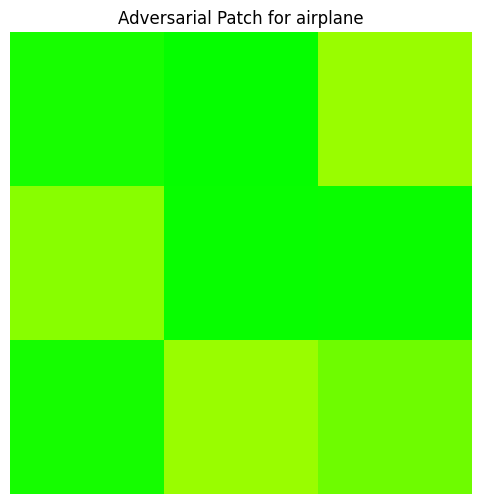

In [ ]:
# Load data
print("Loading CIFAR-10 dataset...")
train_loader, val_loader, class_names = load_cifar10()

# Load model
print("Loading model...")
model, device = load_model()

# Initialize patch generator
patch_generator = PatchGenerator(model, device)

# Initialize patch tester
patch_tester = PatchTester(model, device, patch_generator)

# Generate patches for specific classes
target_classes = ["airplane"]
patch_size = 3  # Start with small patches
results = {}

for target_class in target_classes:
    print(f"\nGenerating patch for class: {target_class}")
    class_idx = class_names.index(target_class)

    # Generate patch
    patch = patch_generator.generate_patch(
        target_class=class_idx, patch_size=patch_size, train_loader=train_loader
    )

    # Evaluate patch
    metrics = patch_tester.evaluate_patch(patch, val_loader, class_idx)
    results[target_class] = metrics

    # Visualize patch
    print(f"\nResults for {target_class}:")
    print(f"Top-1 Success Rate: {metrics['top1_success_rate']:.2%}")
    print(f"Top-5 Success Rate: {metrics['top5_success_rate']:.2%}")
    patch_tester.visualize_patch(patch, f"Adversarial Patch for {target_class}")